<div class="alert alert-block" style="background-color: green; color: white; text-align: center;"><span style="font-size: 14px;"> 
<strong>Direct Variable Selection – MIQP Problem</strong>

Given a dataset of $m$ independent variables, $X$, and a dependent variable, $y$, the standard ordinary least squares problem is formulated as:

$$
\min_{\beta} \sum_{i=1}^{n} (\beta_0 + \beta_1 x_{i1} + \cdots + \beta_m x_{im} - y_i)^2.
$$

To incorporate variable selection into this problem, binary variables, $z_j$, are introduced. These force the corresponding values of $\beta_j$ to be zero if $z_j$ is zero, using the big-M method. If we want to include at most $k$ variables from $X$, then we can pose this as:

$$
\min_{\beta, z} \sum_{i=1}^{n} (\beta_0 + \beta_1 x_{i1} + \cdots + \beta_m x_{im} - y_i)^2
$$

subject to:

$$
-M z_j \leq \beta_j \leq M z_j, \quad \text{for } j = 1, 2, \ldots, m,
$$

$$
\sum_{j=1}^{m} z_j \leq k,
$$

$$
z_j \text{ are binary variables}.
$$

Here, we don’t ever restrict the model from having an intercept term, $\beta_0$. <br>
Note that $m$ and $M$ are different entities; $m$ represents the number of independent variables while $M$ is a large constant used in the big-M method. This Big-M value must be large enough so as not to limit the range of the beta coefficients. <br>
The hyperparameter $k$, representing the maximum number of variables to be included, can be chosen using cross-validation.


<div class="alert alert-block alert-success"><span style="font-size: 14px;"> 
<strong>Step 1: Define the MIQP Optimization Function</strong><br>
    
 - We define a function to perform Mixed-Integer Quadratic Programming (MIQP) optimization, specifying the parameters X (independent variables), y (dependent variable), k (maximum number of variables to select), and time_limit (maximum time allowed for the optimization process). 
 - This function returns the selected variables, their corresponding coefficients, and the intercept term.

In [9]:
from gurobipy import Model, GRB, quicksum
import numpy as np

def variable_selection_MIQP(X, y, k, time_limit):

    n_samples, n_features = X.shape
    
    # Create a new model
    model = Model("variable_selection_MIQP")
    
    # Set the time limit
    model.setParam('TimeLimit', time_limit)
    
    # Define the big-M. This should be sufficiently large to not restrict the beta values when zj=1.
    M = 10000

    # Add variables to the model
    beta = model.addVars(n_features, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="beta")
    z = model.addVars(n_features, vtype=GRB.BINARY, name="z")
    beta0 = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name="beta0")
    
    # Set the objective function
    obj = quicksum((beta0 + quicksum(beta[j] * X[i, j] for j in range(n_features)) - y[i])**2 for i in range(n_samples))
    model.setObjective(obj, GRB.MINIMIZE)
    
    # Add constraints for variable selection
    for j in range(n_features):
        model.addConstr(beta[j] <= M * z[j], "upper_bound_{}".format(j))
        model.addConstr(beta[j] >= -M * z[j], "lower_bound_{}".format(j))
        
    # Constraint on the number of selected variables
    model.addConstr(z.sum() <= k, "k_features")
    
    # Optimize the model
    try:
        # Optimize the model
        model.optimize()

        # Check the status of the optimization
        if model.Status == GRB.OPTIMAL:
            print("Optimization was successful.")
        elif model.Status == GRB.TIME_LIMIT:
            print("Optimization ended due to time limit.")
        elif model.Status == GRB.INFEASIBLE:
            print("Model is infeasible.")
        elif model.Status == GRB.UNBOUNDED:
            print("Model is unbounded.")
        else:
            print("Optimization was stopped with status:", model.Status)

        # Retrieve the selected variables and their coefficients
        selected_variables = [j for j in range(n_features) if z[j].X > 0.5]
        beta_values = [beta[j].X if z[j].X > 0.5 else 0 for j in range(n_features)]
        beta0_value = beta0.X
        
        # Depending on your requirements, you may want to handle suboptimal solutions differently
        return selected_variables, beta_values, beta0_value

    except GurobiError as e:
        print("Error reported by Gurobi:", str(e))

        # Handle the error by returning 'None' or by setting a flag
        return None, None, None


<div class="alert alert-block alert-success"><span style="font-size: 14px;"> 
<strong>Step 2: Define the Manual Cross-Validation Function</strong><br>

 - We implement a function for conducting manual cross-validation. <br> 
The parameters include data (the dataset), target (the target variable), k_values (a list of k-values to iterate over), output_csv (the filename for the CSV to which results will be written), total_time_limit (the overall time constraint for the cross-validation process), and n_folds (the number of folds for cross-validation). <br> 
 - This function will generate a DataFrame results_df with columns specified in results_columns, containing the details of each fold's performance. <br> 
 - The results are continuously saved to a CSV file, ensuring that data is not lost after each fold computation. The function ultimately returns results_df.

In [63]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from gurobipy import GurobiError

def manual_cross_validation(data, target, k_values, output_csv, total_time_limit, n_folds_array):
    random_seed = 15
    np.random.seed(random_seed)
    shuffled_indices = np.random.choice(data.index, size=len(data), replace=False)

    results_columns = ['Fold', 'K', 'Betas', 'Intercept', 'Squared_Error', 'Mean_Squared_Error', 'N_Fold', 'Mean_Squared_Error_train']
    results_df = pd.DataFrame(columns=results_columns)

    start_time = time.time()

    for k in k_values:
        for n_folds in n_folds_array:
            fold_size = len(data) // n_folds
            leftover = len(data) % n_folds
            for fold in range(n_folds):
                current_time = time.time()
                elapsed_time = current_time - start_time
                remaining_time = total_time_limit - elapsed_time

                if remaining_time <= 0:
                    print("Total time limit exceeded. Stopping further processing.")
                    return results_df

                print(f"Processing fold {fold+1} for k={k} with remaining time {remaining_time} seconds...")

                if fold == n_folds - 1:
                    validation_indices = shuffled_indices[fold * fold_size:]
                    fold_size_with_leftover = fold_size + leftover  # Last fold includes the leftover observations
                else:
                    validation_indices = shuffled_indices[fold * fold_size : (fold + 1) * fold_size]
                    fold_size_with_leftover = fold_size

                training_indices = np.setdiff1d(shuffled_indices, validation_indices)

                X_train, y_train = data.iloc[training_indices], target.iloc[training_indices]
                X_val, y_val = data.iloc[validation_indices], target.iloc[validation_indices]

                try:
                    selected_variables, beta_vals, beta0_val = variable_selection_MIQP(X_train.to_numpy(), y_train.to_numpy(), k, time_limit=remaining_time)
                except GurobiError as e:
                    print("Error reported by Gurobi:", str(e))
                    continue

                predictions = np.dot(X_val.to_numpy(), beta_vals) + beta0_val
                mse = mean_squared_error(y_val, predictions)

                predictions_train = np.dot(X_train.to_numpy(), beta_vals) + beta0_val
                mse_train = mean_squared_error(y_train, predictions_train)

                sse = mse * len(y_val)  # SSE is simply MSE scaled by the number of observations

                fold_results = pd.DataFrame([[fold + 1, k, beta_vals, beta0_val, sse, mse, n_folds,mse_train]], columns=results_columns)
                results_df = pd.concat([results_df, fold_results], ignore_index=True)

                # Append the results to the CSV file, create it if it does not exist
                if not os.path.exists(output_csv):
                    fold_results.to_csv(output_csv, mode='w', header=True, index=False)
                else:
                    fold_results.to_csv(output_csv, mode='a', header=False, index=False)

                print(f"Completed fold {fold+1} for k={k}. Results saved to {output_csv}")

    return results_df


<div class="alert alert-block alert-success"><span style="font-size: 14px;"> 
<strong>Step 3: Determine the Best k</strong>
    
 - We begin by importing the training dataset. Then, using the defined range of potential k values, we execute a thorough cross-validation procedure. 
 - Our objective is to identify the k that yields the lowest average Mean Squared Error (MSE), ensuring an optimal balance between model complexity and predictive power for our feature selection process.

In [66]:
# Read in your data
data = pd.read_csv('training_data.csv')

target_column='y'
# Assuming the column 'y' is the target variable and the rest are features
X = data.drop(target_column, axis=1)  # This removes the target column from the feature set
y = data[target_column]  # This selects just the target variable

start_value=5
end_value=51
step_size=5
# Define the range of k values
k_values = [1,10]

n_folds_array=[3,5,10,15,20,25,30,40,50]
time_limit = 43200  # 12 hours in seconds

# File to save the results
output_csv = 'cross_validation_results.csv'

# Make sure to clear out the existing output CSV if it exists
open(output_csv, 'w').close()

# Run the manual cross-validation
results_df = manual_cross_validation(X, y, k_values, output_csv, time_limit,n_folds_array)

# Group the results by 'K' and calculate the mean of the MSE for each 'K'
mean_mses = results_df.groupby('K')['Mean_Squared_Error'].mean()

# Find the best 'K' value with the lowest average MSE
best_k = mean_mses.idxmin()
best_mse = mean_mses.min()

# Find the total SSE for the best 'K'. This is just for additional information and not required to find the best MSE
best_total_error = results_df[results_df['K'] == best_k]['Squared_Error'].sum()

print(f"The best k is {best_k} with an average MSE of {best_mse} across all folds.")

Processing fold 1 for k=1 with remaining time 43200.0 seconds...
Set parameter TimeLimit to value 43200
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xffd41c62
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e-01, 1e+03]
  QObjective range [4e-02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3765.5714816
Presolve time: 0.01s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 int


Solution count 3: 2367.62 3465.3 4367.79 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.367624005568e+03, best bound 2.367624005568e+03, gap 0.0000%
Optimization was successful.
Completed fold 1 for k=1. Results saved to cross_validation_results.csv
Processing fold 2 for k=1 with remaining time 43198.91718459129 seconds...
Set parameter TimeLimit to value 4.3198917184591293e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xebaf6c7b
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+01, 1e+03]
  QObjective 

     0     0     cutoff    0      2404.35035 2404.35035  0.00%     -    0s

Explored 1 nodes (518 simplex iterations) in 0.06 seconds (0.03 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2404.35 4031.96 4356.79 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.404350354840e+03, best bound 2.404350354840e+03, gap 0.0000%
Optimization was successful.
Completed fold 5 for k=1. Results saved to cross_validation_results.csv
Processing fold 1 for k=1 with remaining time 43197.740092515945 seconds...
Set parameter TimeLimit to value 4.3197740092515945e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xf5e1e0

     0     0 2122.92500    0   12 2679.06697 2122.92500  20.8%     -    0s
     0     0     cutoff    0      2679.06697 2679.06697  0.00%     -    0s

Explored 1 nodes (488 simplex iterations) in 0.06 seconds (0.03 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2679.07 4731.16 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.679066971249e+03, best bound 2.679066971249e+03, gap 0.0000%
Optimization was successful.
Completed fold 4 for k=1. Results saved to cross_validation_results.csv
Processing fold 5 for k=1 with remaining time 43196.34391617775 seconds...
Set parameter TimeLimit to value 4.3196343916177750e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 


     0     0  465.59037    0   45 4678.66873  465.59037  90.0%     -    0s
H    0     0                    3818.0492234  465.59037  87.8%     -    0s
H    0     0                    3753.0988205  465.59037  87.6%     -    0s
H    0     0                    2768.3354428  465.59037  83.2%     -    0s
     0     0 2442.14181    0    5 2768.33544 2442.14181  11.8%     -    0s
*    0     0               0    2767.6475346 2767.64753  0.00%     -    0s

Explored 1 nodes (504 simplex iterations) in 0.07 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 4: 2767.65 3753.1 3818.05 4678.67 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.767647534605e+03, best bound 2.767647534605e+03, gap 0.0000%
Optimization was successful.
Completed fold 8 for k=1. Results saved to cross_validation_results.csv
Processing fold 9 for k=1 with remaining time 43194.9626250267 seconds...
Set parameter TimeLimit to value 43194.9626250267
Gurobi Optimizer version


     0     0  466.22599    0   39 5063.06027  466.22599  90.8%     -    0s
H    0     0                    2801.7247409  466.22599  83.4%     -    0s
     0     0 2050.18201    0   11 2801.72474 2050.18201  26.8%     -    0s
     0     0 2768.62026    0    2 2801.72474 2768.62026  1.18%     -    0s
     0     0     cutoff    0      2801.72474 2801.72474  0.00%     -    0s

Explored 1 nodes (479 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2801.72 5063.06 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.801724740896e+03, best bound 2.801724740896e+03, gap 0.0000%
Optimization was successful.
Completed fold 2 for k=1. Results saved to cross_validation_results.csv
Processing fold 3 for k=1 with remaining time 43193.50326871872 seconds...
Set parameter TimeLimit to value 4.3193503268718719e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60


Root relaxation: objective 4.755465e+02, 438 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  475.54654    0   41 4909.42654  475.54654  90.3%     -    0s
H    0     0                    2770.5702202  475.54654  82.8%     -    0s
     0     0 2366.00390    0    7 2770.57022 2366.00390  14.6%     -    0s
     0     0 2746.28175    0    3 2770.57022 2746.28175  0.88%     -    0s
*    0     0               0    2770.0276628 2770.02766  0.00%     -    0s

Explored 1 nodes (499 simplex iterations) in 0.06 seconds (0.03 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2770.03 4909.43 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.770027662801e+03, best bound 2.770027662801e+03, gap 0.0000%
Optimization was successful.
Completed fold 6 for k=1. Results saved to cross_validation_results.cs

Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.734107e+02, 422 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  473.41066    0   46 4955.17884  473.41066  90.4%     -    0s
H    0     0                    4176.0846603  473.41066  88.7%     -    0s
H    0     0                    3276.9232803  473.41066  85.6%     -    0s
H    0     0                    2797.5403073  473.41066  83.1%     -    0s
     0     0 2461.41795    0    5 2797.54031 2461.41795  12.0%     -    0s
     0     0     cutoff    0      2797.54031 2797.54031  0.00%     -    0s

Explored 1 nodes (478 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 4: 2797.54 3276.92 4176.08 4955.18 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.797540307346e+0

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5005.7502838
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.931059e+02, 430 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  493.10594    0   42 5005.75028  493.10594  90.1%     -    0s
H    0     0                    4145.8652029  493.10594  88.1%     -    0s
H    0     0                    2782.9901909  493.10594  82.3%     -    0s
     0     0 2246.33458    0    8 2782.99019 2246.33458  19.3%     -    0s
     0     0          -    0      2782.99019 2782.94684  0.00%     -    0s

Explored 1 nodes (490 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 

Model fingerprint: 0x157243ae
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+01, 2e+03]
  QObjective range [2e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5106.8001076
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.065572e+02, 436 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  506.55724    0   41 5106.80011  506.55724  90.1%     -    0s
H    0     0                    2906.5711491  506.55724  82.6%     -    0s
     0     0 2279.94546    0    9 2906.57115 2279.94546  21.6%     -

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xd447c397
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e+00, 2e+03]
  QObjective range [1e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5086.3241004
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.991489e+02, 436 iterations, 0.01 seconds (0.01 work units

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xb33aa6e1
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [7e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4967.0768935
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.979941e+02, 444 iterations, 0.01 seconds (0.01 work units


CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x60f01f55
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [1e-01, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5092.3097636
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.098806e+02, 438 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Boun

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x86d86199
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e-01, 2e+03]
  QObjective range [2e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5094.0813147
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.032796e+02, 460 iterations, 0.00 seconds (0.01 work units

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xd06f6f7d
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [7e+00, 2e+03]
  QObjective range [3e-03, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5154.7706354
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.947052e+02, 428 iterations, 0.00 seconds (0.01 work units

Optimization was successful.
Completed fold 6 for k=1. Results saved to cross_validation_results.csv
Processing fold 7 for k=1 with remaining time 43180.00925254822 seconds...
Set parameter TimeLimit to value 4.3180009252548218e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xf2d494d9
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 2e+03]
  QObjective range [5e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5118.3516293
Presolve time: 0.00s
Presolv

Optimization was successful.
Completed fold 10 for k=1. Results saved to cross_validation_results.csv
Processing fold 11 for k=1 with remaining time 43178.67542004585 seconds...
Set parameter TimeLimit to value 4.3178675420045853e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x06067b10
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 2e+03]
  QObjective range [2e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5054.0133564
Presolve time: 0.00s
Preso


Optimal solution found (tolerance 1.00e-04)
Best objective 2.810552471541e+03, best bound 2.810552471541e+03, gap 0.0000%
Optimization was successful.
Completed fold 14 for k=1. Results saved to cross_validation_results.csv
Processing fold 15 for k=1 with remaining time 43177.33831501007 seconds...
Set parameter TimeLimit to value 4.3177338315010071e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xe5da3f03
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [1e-01, 8e+02]
  Bounds range     [

Thread count was 12 (of 12 available processors)

Solution count 3: 2945.64 4542.78 5150.87 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.945636320345e+03, best bound 2.945636320345e+03, gap 0.0000%
Optimization was successful.
Completed fold 18 for k=1. Results saved to cross_validation_results.csv
Processing fold 19 for k=1 with remaining time 43176.051414489746 seconds...
Set parameter TimeLimit to value 4.3176051414489746e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xb6c62235
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1

Thread count was 12 (of 12 available processors)

Solution count 3: 2924.04 4645.73 5204.35 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.924035917071e+03, best bound 2.924035917071e+03, gap 0.0000%
Optimization was successful.
Completed fold 22 for k=1. Results saved to cross_validation_results.csv
Processing fold 23 for k=1 with remaining time 43174.73288965225 seconds...
Set parameter TimeLimit to value 4.3174732889652252e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xef015415
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xea84c965
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5163.2407847
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.939288e+02, 406 iterations, 0.00 seconds (0.01 work units

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xf71974f8
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [2e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5087.6621974
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.111568e+02, 451 iterations, 0.00 seconds (0.01 work units

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x9e93e37c
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e-03, 2e+03]
  QObjective range [4e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5140.2090899
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.037252e+02, 440 iterations, 0.02 seconds (0.01 work units


Solution count 3: 2949.75 4634.15 5109.51 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.949752892869e+03, best bound 2.949752892869e+03, gap 0.0000%
Optimization was successful.
Completed fold 13 for k=1. Results saved to cross_validation_results.csv
Processing fold 14 for k=1 with remaining time 43168.989297151566 seconds...
Set parameter TimeLimit to value 4.3168989297151566e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xdbcc5794
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+01, 2e+03]
  QObject


Explored 1 nodes (504 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2831.18 3346.7 5102.87 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.831182683125e+03, best bound 2.831134255136e+03, gap 0.0017%
Optimization was successful.
Completed fold 17 for k=1. Results saved to cross_validation_results.csv
Processing fold 18 for k=1 with remaining time 43167.48945212364 seconds...
Set parameter TimeLimit to value 4.3167489452123642e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x37be51dc
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 

Thread count was 12 (of 12 available processors)

Solution count 4: 2935.65 4106.19 4305.3 5211.57 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.935651279491e+03, best bound 2.935651279491e+03, gap 0.0000%
Optimization was successful.
Completed fold 21 for k=1. Results saved to cross_validation_results.csv
Processing fold 22 for k=1 with remaining time 43166.171810388565 seconds...
Set parameter TimeLimit to value 4.3166171810388565e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xde3b4093
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1

H    0     0                    2897.4671365  506.38697  82.5%     -    0s
     0     0 2228.41543    0    7 2897.46714 2228.41543  23.1%     -    0s
     0     0 2892.82643    0    2 2897.46714 2892.82643  0.16%     -    0s
     0     0     cutoff    0      2897.46714 2897.46714  0.00%     -    0s

Explored 1 nodes (476 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 4: 2897.47 3422.69 3980.16 5017.19 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.897467136474e+03, best bound 2.897467136474e+03, gap 0.0000%
Optimization was successful.
Completed fold 25 for k=1. Results saved to cross_validation_results.csv
Processing fold 26 for k=1 with remaining time 43164.80642747879 seconds...
Set parameter TimeLimit to value 4.3164806427478790e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physi


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  514.96810    0   40 5210.60250  514.96810  90.1%     -    0s
H    0     0                    4247.5739659  514.96810  87.9%     -    0s
H    0     0                    2930.0905705  514.96810  82.4%     -    0s
     0     0 2339.61896    0    9 2930.09057 2339.61896  20.2%     -    0s
     0     0 2885.75404    0    2 2930.09057 2885.75404  1.51%     -    0s
*    0     0               0    2929.7670237 2929.76702  0.00%     -    0s

Explored 1 nodes (489 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2929.77 4247.57 5210.6 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.929767023675e+03, best bound 2.929767023675e+03, gap 0.0000%
Optimization was successful.
Completed fold 29 for k=1. Results saved to cross_validation_results.csv
Proc


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  487.89993    0   43 5190.84408  487.89993  90.6%     -    0s
H    0     0                    4126.9506029  487.89993  88.2%     -    0s
H    0     0                    2919.1926477  487.89993  83.3%     -    0s
     0     0 2344.81134    0    6 2919.19265 2344.81134  19.7%     -    0s
     0     0 2886.56288    0    3 2919.19265 2886.56288  1.12%     -    0s
     0     0     cutoff    0      2919.19265 2919.19265  0.00%     -    0s

Explored 1 nodes (501 simplex iterations) in 0.08 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2919.19 4126.95 5190.84 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.919192647733e+03, best bound 2.919192647733e+03, gap 0.0000%
Optimization was successful.
Completed fold 3 for k=1. Results saved to cross_validation_results.csv
Proc


Root relaxation: objective 4.882084e+02, 412 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  488.20835    0   43 5212.26272  488.20835  90.6%     -    0s
H    0     0                    4242.2069511  488.20835  88.5%     -    0s
H    0     0                    2944.8257508  488.20835  83.4%     -    0s
     0     0 2536.98163    0    5 2944.82575 2536.98163  13.8%     -    0s
     0     0 2923.70987    0    2 2944.82575 2923.70987  0.72%     -    0s
*    0     0               0    2944.4945347 2944.49453  0.00%     -    0s

Explored 1 nodes (490 simplex iterations) in 0.08 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2944.49 4242.21 5212.26 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.944494534667e+03, best bound 2.944494534667e+03, gap 0.0000%
Optimization was


Root relaxation: objective 5.057384e+02, 434 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  505.73840    0   37 5226.44778  505.73840  90.3%     -    0s
H    0     0                    2939.2371592  505.73840  82.8%     -    0s
     0     0 2212.35348    0   11 2939.23716 2212.35348  24.7%     -    0s
     0     0 2866.13212    0    3 2939.23716 2866.13212  2.49%     -    0s
*    0     0               0    2937.7652351 2937.76524  0.00%     -    0s

Explored 1 nodes (501 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2937.77 5226.45 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.937765235127e+03, best bound 2.937765235127e+03, gap 0.0000%
Optimization was successful.
Completed fold 11 for k=1. Results saved to cross_validation_results.c

Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.969879e+02, 410 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  496.98793    0   43 5091.19966  496.98793  90.2%     -    0s
H    0     0                    4430.4630392  496.98793  88.8%     -    0s
H    0     0                    2886.2962772  496.98793  82.8%     -    0s
     0     0 2484.80590    0    8 2886.29628 2484.80590  13.9%     -    0s
     0     0     cutoff    0      2886.29628 2886.29628  0.00%     -    0s

Explored 1 nodes (468 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2886.3 4430.46 5091.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.886296277209e+03, best bound 2.886296277209e+03, gap 0.0000%
Optimization was successful.
Completed 

Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.167476e+02, 436 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  516.74760    0   42 5218.10894  516.74760  90.1%     -    0s
H    0     0                    2966.7428522  516.74760  82.6%     -    0s
     0     0 2381.46991    0    8 2966.74285 2381.46991  19.7%     -    0s
     0     0          -    0      2966.74285 2966.63488  0.00%     -    0s

Explored 1 nodes (496 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2966.74 5218.11 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.966742852243e+03, best bound 2.966634876866e+03, gap 0.0036%
O

Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.026856e+02, 440 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  502.68564    0   41 5192.65809  502.68564  90.3%     -    0s
H    0     0                    4759.5607339  502.68564  89.4%     -    0s
H    0     0                    2872.1780034  502.68564  82.5%     -    0s
     0     0 2245.56986    0    7 2872.17800 2245.56986  21.8%     -    0s
     0     0 2825.30347    0    3 2872.17800 2825.30347  1.63%     -    0s
*    0     0               0    2871.7720365 2871.77204  0.00%     -    0s

Explored 1 nodes (499 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2871.77 4759.56 5192.66 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.871772036513e+03, best 

Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.000805e+02, 432 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  500.08048    0   44 5250.88440  500.08048  90.5%     -    0s
H    0     0                    2933.2788185  500.08048  83.0%     -    0s
     0     0 2448.01028    0    6 2933.27882 2448.01028  16.5%     -    0s
     0     0 2926.05183    0    2 2933.27882 2926.05183  0.25%     -    0s
     0     0     cutoff    0      2933.27882 2933.27882  0.00%     -    0s

Explored 1 nodes (495 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2933.28 5250.88 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.933278818529e+03, best bound 2.933278818529e+03, gap 0.0000%
Optimization was successful.
Completed fold 2


Root relaxation: objective 5.039469e+02, 434 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  503.94688    0   41 5260.55460  503.94688  90.4%     -    0s
H    0     0                    2922.0948789  503.94688  82.8%     -    0s
     0     0 2322.87946    0    8 2922.09488 2322.87946  20.5%     -    0s
     0     0 2916.55146    0    2 2922.09488 2916.55146  0.19%     -    0s
     0     0          -    0      2922.09488 2922.09355  0.00%     -    0s

Explored 1 nodes (493 simplex iterations) in 0.08 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2922.09 5260.55 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.922094878886e+03, best bound 2.922093551933e+03, gap 0.0000%
Optimization was successful.
Completed fold 31 for k=1. Results saved to cross_validation_results.c

Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.071581e+02, 424 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  507.15812    0   42 5236.04604  507.15812  90.3%     -    0s
H    0     0                    3502.8863016  507.15812  85.5%     -    0s
H    0     0                    2943.0332160  507.15812  82.8%     -    0s
     0     0 2522.57837    0    7 2943.03322 2522.57837  14.3%     -    0s
     0     0 2897.84327    0    2 2943.03322 2897.84327  1.54%     -    0s
     0     0          -    0      2943.03322 2942.76144  0.01%     -    0s

Explored 1 nodes (487 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2943.03 3502

Found heuristic solution: objective 5170.3298226
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.135376e+02, 398 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  513.53757    0   40 5170.32982  513.53757  90.1%     -    0s
H    0     0                    4211.6905943  513.53757  87.8%     -    0s
H    0     0                    2922.0806340  513.53757  82.4%     -    0s
     0     0 2328.52120    0   10 2922.08063 2328.52120  20.3%     -    0s
     0     0          -    0      2922.08063 2921.88679  0.01%     -    0s

Explored 1 nodes (458 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2922.08 4211.69 5

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5208.3736079
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.025264e+02, 404 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  502.52636    0   42 5208.37361  502.52636  90.4%     -    0s
H    0     0                    4753.8956297  502.52636  89.4%     -    0s
H    0     0                    4281.9328383  502.52636  88.3%     -    0s
H    0     0                    2946.2116423  502.52636  82.9%     -    0s
     0     0 2394.64213    0    8 2946.21164 2394.64213  18.7%     -    0s
*    0     0               0    2945.2046489 2945.20465  0.00%     -    0s

Explored 1 nodes (

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xe22e85fb
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [4e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5268.4732973
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.206891e+02, 416 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xd54c88a2
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5294.7069474
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.967591e+02, 414 iterations, 0.00 seconds (0.01 work units

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xf181f61c
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+00, 2e+03]
  QObjective range [5e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5228.3494477
Presolve time: 0.02s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.171447e+02, 430 iterations, 0.00 seconds (0.01 work units

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xf982aff5
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+01, 2e+03]
  QObjective range [1e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5278.2655506
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.081804e+02, 406 iterations, 0.02 seconds (0.01 work units

Best objective 2.928152928183e+03, best bound 2.928152928183e+03, gap 0.0000%
Optimization was successful.
Completed fold 22 for k=1. Results saved to cross_validation_results.csv
Processing fold 23 for k=1 with remaining time 43138.41265916824 seconds...
Set parameter TimeLimit to value 4.3138412659168243e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xc6d8420d
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+0


Explored 1 nodes (495 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2920.92 4577.09 5152.72 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.920915018040e+03, best bound 2.920914532200e+03, gap 0.0000%
Optimization was successful.
Completed fold 26 for k=1. Results saved to cross_validation_results.csv
Processing fold 27 for k=1 with remaining time 43136.82741355896 seconds...
Set parameter TimeLimit to value 4.3136827413558960e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x95e08033
Model has 1326 quadratic objective terms
Variable types: 51 continuous,


Optimal solution found (tolerance 1.00e-04)
Best objective 2.963572372734e+03, best bound 2.963572372734e+03, gap 0.0000%
Optimization was successful.
Completed fold 30 for k=1. Results saved to cross_validation_results.csv
Processing fold 31 for k=1 with remaining time 43135.2272336483 seconds...
Set parameter TimeLimit to value 43135.2272336483
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xd67b82c4
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 


Solution count 2: 2932.94 5241.69 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.932935077038e+03, best bound 2.932924794012e+03, gap 0.0004%
Optimization was successful.
Completed fold 34 for k=1. Results saved to cross_validation_results.csv
Processing fold 35 for k=1 with remaining time 43133.72122836113 seconds...
Set parameter TimeLimit to value 4.3133721228361130e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xecca249d
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range

Best objective 2.962419471760e+03, best bound 2.962156436216e+03, gap 0.0089%
Optimization was successful.
Completed fold 38 for k=1. Results saved to cross_validation_results.csv
Processing fold 39 for k=1 with remaining time 43132.230038166046 seconds...
Set parameter TimeLimit to value 4.3132230038166046e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x779bace1
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+

Thread count was 12 (of 12 available processors)

Solution count 3: 2954.79 4272.66 5245.24 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.954789756933e+03, best bound 2.954789756933e+03, gap 0.0000%
Optimization was successful.
Completed fold 42 for k=1. Results saved to cross_validation_results.csv
Processing fold 43 for k=1 with remaining time 43130.69259476662 seconds...
Set parameter TimeLimit to value 4.3130692594766617e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x7b014afe
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e

     0     0          -    0      2947.03352 2946.83132  0.01%     -    0s

Explored 1 nodes (506 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 2947.03 3537.28 5251.94 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.947033515505e+03, best bound 2.946831315049e+03, gap 0.0069%
Optimization was successful.
Completed fold 46 for k=1. Results saved to cross_validation_results.csv
Processing fold 47 for k=1 with remaining time 43129.10776925087 seconds...
Set parameter TimeLimit to value 4.3129107769250870e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x2c407

     0     0 2335.95597    0    8 2965.34153 2335.95597  21.2%     -    0s
     0     0 2923.41230    0    3 2965.34153 2923.41230  1.41%     -    0s
     0     0     cutoff    0      2965.34153 2965.34153  0.00%     -    0s

Explored 1 nodes (501 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 2965.34 5210.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.965341532644e+03, best bound 2.965341532644e+03, gap 0.0000%
Optimization was successful.
Completed fold 50 for k=1. Results saved to cross_validation_results.csv
Processing fold 1 for k=10 with remaining time 43127.61723732948 seconds...
Set parameter TimeLimit to value 4.3127617237329483e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non

H 1207   451                     449.7232441  371.16098  17.5%   7.7    0s
H 2764   937                     449.6221239  383.61911  14.7%   7.8    0s
H15994  3608                     449.5544481  383.61911  14.7%   7.1    2s
H16083  3594                     448.4260582  383.61911  14.5%   7.1    2s
 58086  7787  419.90535   30   25  448.42606  398.44270  11.1%   6.6    5s
 148652  7336     cutoff   43       448.42606  427.04946  4.77%   6.3   10s

Explored 202874 nodes (1253184 simplex iterations) in 12.83 seconds (19.88 work units)
Thread count was 12 (of 12 available processors)

Solution count 9: 448.426 453.049 454.334 ... 3579.08

Optimal solution found (tolerance 1.00e-04)
Best objective 4.484260581887e+02, best bound 4.484260581887e+02, gap 0.0000%
Optimization was successful.
Completed fold 3 for k=10. Results saved to cross_validation_results.csv
Processing fold 1 for k=10 with remaining time 43091.63882899284 seconds...
Set parameter TimeLimit to value 4.3091638828992844e+04


H    0     0                     714.9439904  373.52192  47.8%     -    0s
H    0     0                     710.2971213  373.52192  47.4%     -    0s
H    0     0                     641.6915597  373.52192  41.8%     -    0s
     0     0  373.52192    0   42  641.69156  373.52192  41.8%     -    0s
H    0     0                     614.3715513  373.52192  39.2%     -    0s
     0     2  373.52192    0   42  614.37155  373.52192  39.2%     -    0s
H   79    63                     576.7927522  373.93417  35.2%   7.4    0s
H  127    85                     466.7874734  373.93417  19.9%   7.8    0s
H  193   115                     462.4788399  373.93417  19.1%   7.8    0s
H  228   115                     461.5711064  373.93417  19.0%   7.9    0s
*  237   135              34     460.1255279  373.93417  18.7%   7.9    0s
H  283   163                     450.6448259  373.93417  17.0%   7.7    0s
H  311   163                     445.2265494  373.93417  16.0%   7.8    0s
H  460   201             


Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xc842b5ea
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [9e-01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 4892.4911894
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.222192e+02, 378 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  422.21918    0   36 4892.49119  422.21918  91.4%     -

H  268   122                     523.2807664  454.83409  13.1%   8.6    0s
H  482   227                     522.4649425  454.83409  12.9%   8.4    0s
H 9080     5                     522.1080830  515.24368  1.31%   6.9    1s

Explored 9121 nodes (63110 simplex iterations) in 1.06 seconds (2.07 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 522.108 523.281 527.869 ... 559.907

Optimal solution found (tolerance 1.00e-04)
Best objective 5.221080829551e+02, best bound 5.221080829551e+02, gap 0.0000%
Optimization was successful.
Completed fold 3 for k=10. Results saved to cross_validation_results.csv
Processing fold 4 for k=10 with remaining time 43055.82456302643 seconds...
Set parameter TimeLimit to value 4.3055824563026428e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic

H  180    93                     526.8654939  446.86695  15.2%   8.2    0s
H  196   103                     515.3596425  446.86695  13.3%   8.0    0s
H  270   116                     515.2581820  447.09751  13.2%   7.6    0s
H 1907   668                     515.1299229  455.92229  11.5%   7.5    0s
H 3347   937                     515.1290081  462.89641  10.1%   7.3    0s
H 5497  1035                     514.6621662  469.75959  8.72%   7.0    0s
H13521   705                     513.9753545  478.88133  6.83%   7.0    1s
H16412   891                     513.9737035  481.36866  6.34%   7.0    2s

Explored 32398 nodes (214333 simplex iterations) in 3.02 seconds (5.89 work units)
Thread count was 12 (of 12 available processors)

Solution count 9: 513.974 526.865 560.057 ... 4584.38

Optimal solution found (tolerance 1.00e-04)
Best objective 5.139737034542e+02, best bound 5.139737034542e+02, gap 0.0000%
Optimization was successful.
Completed fold 6 for k=10. Results saved to cross_validation

H    0     0                     558.7266857  475.89421  14.8%     -    0s
     0     2  475.89421    0   39  558.72669  475.89421  14.8%     -    0s
H   70    48                     554.6151835  482.38545  13.0%   7.9    0s
H  137    58                     554.0944653  482.38545  12.9%   8.3    0s
H  464   158                     550.4383560  485.87092  11.7%   7.8    0s
H  559   179                     550.3851065  487.23723  11.5%   7.7    0s
H  891   210                     550.3821790  488.58596  11.2%   7.0    0s
H  999   215                     549.3670542  488.58596  11.1%   6.9    0s

Explored 32602 nodes (202563 simplex iterations) in 3.22 seconds (5.47 work units)
Thread count was 12 (of 12 available processors)

Solution count 7: 549.367 554.094 558.727 ... 4808.75

Optimal solution found (tolerance 1.00e-04)
Best objective 5.493670542284e+02, best bound 5.493670542284e+02, gap 0.0000%
Optimization was successful.
Completed fold 9 for k=10. Results saved to cross_validation

H    0     0                     839.3750836  466.22599  44.5%     -    0s
H    0     2                     824.8240641  466.22599  43.5%     -    0s
     0     2  466.22599    0   32  824.82406  466.22599  43.5%     -    0s
H   31    38                     824.7228123  466.22599  43.5%  11.0    0s
H   33    38                     818.8744074  466.22599  43.1%  10.5    0s
H   35    38                     796.9184428  466.22599  41.5%  10.3    0s
*   63    54              10     754.5377208  466.22835  38.2%  10.0    0s
H   67    55                     748.5611645  466.22835  37.7%   9.6    0s
H   68    55                     745.1546227  466.22835  37.4%   9.5    0s
H   77    55                     629.3711538  466.22835  25.9%   9.2    0s
H  127    88                     622.6177945  466.96214  25.0%   8.9    0s
*  136    88              16     618.5335750  466.96214  24.5%   9.0    0s
H  152    88                     616.8310321  466.96214  24.3%   8.8    0s
H  193   106             

H  200   122                     600.6018420  479.49303  20.2%   9.0    0s
H  207   122                     599.9097253  479.49303  20.1%   8.9    0s
H  292   166                     562.6601979  479.49303  14.8%   8.8    0s
H  320   166                     561.1882217  479.49303  14.6%   8.9    0s
H  408   208                     557.8308679  479.49303  14.0%   8.8    0s
H  422   208                     552.5362250  479.49303  13.2%   8.8    0s
H 1089   355                     551.6779579  487.79403  11.6%   7.8    0s
H 1125   353                     550.9656789  487.79403  11.5%   7.8    0s

Explored 21244 nodes (145228 simplex iterations) in 1.76 seconds (3.01 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 550.966 557.831 561.188 ... 744.836

Optimal solution found (tolerance 1.00e-04)
Best objective 5.509656789124e+02, best bound 5.509656789124e+02, gap 0.0000%
Optimization was successful.
Completed fold 4 for k=10. Results saved to cross_validatio

H12779  1027                     546.3607617  507.93613  7.03%   7.1    1s

Explored 32544 nodes (221213 simplex iterations) in 2.77 seconds (5.32 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 546.361 549.57 550.783 ... 629.398

Optimal solution found (tolerance 1.00e-04)
Best objective 5.463607616505e+02, best bound 5.463607616505e+02, gap 0.0000%
Optimization was successful.
Completed fold 6 for k=10. Results saved to cross_validation_results.csv
Processing fold 7 for k=10 with remaining time 43008.70170688629 seconds...
Set parameter TimeLimit to value 4.3008701706886292e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fi

Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.810213e+02, 440 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  481.02125    0   34 4910.25734  481.02125  90.2%     -    0s
H    0     0                    1627.6995365  481.02125  70.4%     -    0s
     0     0  481.02125    0   34 1627.69954  481.02125  70.4%     -    0s
H    0     0                     808.3328218  481.02125  40.5%     -    0s
     0     2  481.02125    0   34  808.33282  481.02125  40.5%     -    0s
*   92    75              14     640.0535492  481.02125  24.8%   8.7    0s
*  108    69              15     639.9985931  481.02125  24.8%   8.4    0s
*  110    69              16     639.6343780  481.02125  24.8%   8.6    0s
*  112    69              15     637.6359085  481.0212

H  293   202                     620.1085111  488.80539  21.2%   8.2    0s
H  313   202                     604.0241769  488.80539  19.1%   8.0    0s
H  411   297                     596.9903548  488.80539  18.1%   7.8    0s
H  414   297                     579.6208360  488.80539  15.7%   7.8    0s
H  445   297                     568.6178601  488.80539  14.0%   7.7    0s
H  807   372                     563.6315509  488.80539  13.3%   7.3    0s
H  870   323                     563.2143235  488.80539  13.2%   7.2    0s
H  884   323                     563.0848164  488.80539  13.2%   7.2    0s
H 3970   921                     562.7849632  497.12036  11.7%   6.7    0s
H10607  1055                     562.2867978  521.89734  7.18%   7.0    1s
H15183   982                     562.1685719  539.80610  3.98%   6.8    1s

Explored 21894 nodes (146599 simplex iterations) in 2.16 seconds (4.08 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 562.169 568.618 579.62

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  493.10594    0   40 5005.75028  493.10594  90.1%     -    0s
H    0     0                    1519.4375642  493.10594  67.5%     -    0s
H    0     0                    1365.9929389  493.10594  63.9%     -    0s
H    0     0                    1260.7036575  493.10594  60.9%     -    0s
     0     0  493.10594    0   40 1260.70366  493.10594  60.9%     -    0s
H    0     0                    1236.5219545  493.10594  60.1%     -    0s
H    0     0                    1197.3701426  493.10594  58.8%     -    0s
H    0     0                     581.3310676  493.10594  15.2%     -    0s
     0     2  493.10594    0   38  581.33107  493.10594  15.2%     -    0s
H  194    85                     576.6089606  496.11526  14.0%   8.6    0s
H  214    85                     572.9608613  496.11526  13.4%   8.9    0s
H  411   105                     568.9720094  496.36007  12.8%   8.2    0s
H  606   150          

  QObjective range [2e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5119.1048617
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.676849e+02, 364 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  467.68488    0   35 5119.10486  467.68488  90.9%     -    0s
H    0     0                    2190.1863700  467.68488  78.6%     -    0s
H    0     0                    1156.6052522  467.68488  59.6%     -    0s
     0     0  467.68488    0   35 1156.60525  467.68488  59.6%     -    0s
H    0     2                    1042.1333914  467.68488  55.1%     -    0s
     0     2  467.68488    0   35 1042.13339  467.68488  55.

Optimization was successful.
Completed fold 4 for k=10. Results saved to cross_validation_results.csv
Processing fold 5 for k=10 with remaining time 42969.499608039856 seconds...
Set parameter TimeLimit to value 4.2969499608039856e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xa5ed4418
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [4e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5144.6050577
Presolve time: 0.00s
Pres

H    0     0                     675.7725996  499.14888  26.1%     -    0s
H    0     0                     675.0942544  499.14888  26.1%     -    0s
H    0     0                     644.7614797  499.14888  22.6%     -    0s
H    0     0                     630.9825543  499.14888  20.9%     -    0s
     0     0  499.14888    0   36  630.98255  499.14888  20.9%     -    0s
     0     0  499.14888    0   36  630.98255  499.14888  20.9%     -    0s
H    0     0                     585.8678099  499.14888  14.8%     -    0s
     0     2  499.14888    0   36  585.86781  499.14888  14.8%     -    0s
H   70    49                     584.8116501  500.30027  14.5%   8.8    0s
H  127    68                     584.1726532  500.30027  14.4%   9.0    0s
H  127    68                     583.7275680  500.30027  14.3%   9.0    0s
H  132    68                     574.4533994  500.30027  12.9%   8.9    0s
H  152    68                     573.2617628  500.30027  12.7%   8.6    0s
H  193   102             


CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xf5bb8da0
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [1e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5093.0187564
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.016962e+02, 331 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Boun


Solution count 10: 565.263 579.197 591.076 ... 5021.91

Optimal solution found (tolerance 1.00e-04)
Best objective 5.652630238699e+02, best bound 5.652630238699e+02, gap 0.0000%
Optimization was successful.
Completed fold 12 for k=10. Results saved to cross_validation_results.csv
Processing fold 13 for k=10 with remaining time 42942.67047572136 seconds...
Set parameter TimeLimit to value 4.2942670475721359e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x828962e5
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+

Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.098806e+02, 319 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  509.88060    0   36 5092.30976  509.88060  90.0%     -    0s
H    0     0                    1382.7527868  509.88060  63.1%     -    0s
     0     0  509.88060    0   36 1382.75279  509.88060  63.1%     -    0s
H    0     0                     625.1148462  509.88060  18.4%     -    0s
     0     1  509.88060    0   36  625.11485  509.88060  18.4%     -    0s
H  105    63                     614.2232315  511.67845  16.7%   9.0    0s
H  194    95                     604.2558129  514.93258  14.8%   8.6    0s
H  201    95                     585.8463144  514.93258  12.1%   8.6    0s
H 1084   410                     583.5019245  518.69210  11.1%   7.8    0s
H 1645   593                  

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x76769e64
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5159.3110037
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.939274e+02, 347 iterations, 0.00 seconds (0.01 work units

     0     0  469.83339    0   40  618.47140  469.83339  24.0%     -    0s
H    0     0                     616.1347275  469.83339  23.7%     -    0s
     0     2  469.83339    0   40  616.13473  469.83339  23.7%     -    0s
H   29    32                     611.9965457  469.83339  23.2%   8.7    0s
H   59    62                     610.4144603  471.40305  22.8%   7.9    0s
H   70    66                     605.9788472  471.40305  22.2%   8.1    0s
H   70    66                     598.8119510  471.40305  21.3%   8.1    0s
H  106    75                     563.1149989  473.36177  15.9%   8.1    0s
H  336   112                     562.4690292  478.50525  14.9%   8.3    0s
H  841   188                     559.9434989  479.92076  14.3%   6.8    0s
H 1946   215                     558.7678171  487.99545  12.7%   6.2    0s
H11184  1459                     558.5007385  500.43860  10.4%   6.2    1s

Explored 34029 nodes (205556 simplex iterations) in 2.74 seconds (4.87 work units)
Thread count was

Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.947052e+02, 441 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  494.70516    0   31 5154.77064  494.70516  90.4%     -    0s
H    0     0                    1305.2201359  494.70516  62.1%     -    0s
H    0     0                    1287.9205793  494.70516  61.6%     -    0s
     0     0  494.70516    0   31 1287.92058  494.70516  61.6%     -    0s
H    0     0                     736.6290175  494.70516  32.8%     -    0s
H    0     2                     727.6077009  494.70516  32.0%     -    0s
     0     2  494.70516    0   31  727.60770  494.70516  32.0%     -    0s
H   30    36                     718.6586547  494.70516  31.2%  11.2    0s
H   51    47                     620.6683952  494.7051

H 3598  1050                     589.6337336  528.81493  10.3%   7.8    0s
H 4545   916                     588.4067751  528.81493  10.1%   7.7    0s

Explored 30815 nodes (202407 simplex iterations) in 2.45 seconds (4.54 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 588.407 590.87 591.814 ... 782.464

Optimal solution found (tolerance 1.00e-04)
Best objective 5.884067751489e+02, best bound 5.884067751489e+02, gap 0.0000%
Optimization was successful.
Completed fold 5 for k=10. Results saved to cross_validation_results.csv
Processing fold 6 for k=10 with remaining time 42879.97720050812 seconds...
Set parameter TimeLimit to value 4.2879977200508118e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexa

H    0     0                    1715.4754369  501.37002  70.8%     -    0s
H    0     0                    1593.6042849  501.37002  68.5%     -    0s
H    0     0                    1545.4327144  501.37002  67.6%     -    0s
H    0     0                    1450.0258197  501.37002  65.4%     -    0s
H    0     0                    1407.9740377  501.37002  64.4%     -    0s
H    0     0                    1397.2135124  501.37002  64.1%     -    0s
H    0     0                    1322.4818915  501.37002  62.1%     -    0s
H    0     0                     686.9946451  501.37002  27.0%     -    0s
H    0     0                     682.1975189  501.37002  26.5%     -    0s
H    0     0                     677.2930107  501.37002  26.0%     -    0s
H    0     0                     659.2617017  501.37002  23.9%     -    0s
H    0     0                     653.3626177  501.37002  23.3%     -    0s
H    0     0                     640.9246448  501.37002  21.8%     -    0s
     0     0  501.37002  

H15118  2552                     559.6751016  511.23249  8.66%   5.8    2s

Explored 53436 nodes (318035 simplex iterations) in 3.97 seconds (6.89 work units)
Thread count was 12 (of 12 available processors)

Solution count 9: 559.675 560.934 562.596 ... 5128.6

Optimal solution found (tolerance 1.00e-04)
Best objective 5.596751016016e+02, best bound 5.596751016016e+02, gap 0.0000%
Optimization was successful.
Completed fold 10 for k=10. Results saved to cross_validation_results.csv
Processing fold 11 for k=10 with remaining time 42863.771567344666 seconds...
Set parameter TimeLimit to value 4.2863771567344666e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model 

Thread count was 12 (of 12 available processors)

Solution count 5: 572.125 577.146 584.722 ... 5021.84

Optimal solution found (tolerance 1.00e-04)
Best objective 5.721249704477e+02, best bound 5.721249704477e+02, gap 0.0000%
Optimization was successful.
Completed fold 13 for k=10. Results saved to cross_validation_results.csv
Processing fold 14 for k=10 with remaining time 42855.169951200485 seconds...
Set parameter TimeLimit to value 4.2855169951200485e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x64406068
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range 


     0     0  502.97364    0   38 5168.15020  502.97364  90.3%     -    0s
H    0     0                    2118.5655316  502.97364  76.3%     -    0s
H    0     0                    1514.9470647  502.97364  66.8%     -    0s
     0     0  502.97364    0   38 1514.94706  502.97364  66.8%     -    0s
H    0     0                     586.2249304  502.97364  14.2%     -    0s
     0     2  502.97364    0   37  586.22493  502.97364  14.2%     -    0s
H  208   102                     585.5423050  503.57179  14.0%   7.7    0s
H  221   102                     581.6942014  503.57179  13.4%   7.5    0s
H  603   208                     581.4059082  515.89411  11.3%   7.3    0s
H 1966   424                     581.3059431  535.37859  7.90%   7.8    0s
H 2231   482                     580.9621060  536.19265  7.71%   7.9    0s

Explored 8799 nodes (59829 simplex iterations) in 1.02 seconds (2.29 work units)
Thread count was 12 (of 12 available processors)

Solution count 7: 580.962 581.306 585.542 

  QObjective range [1e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5131.2391946
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.926137e+02, 344 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  492.61370    0   33 5131.23919  492.61370  90.4%     -    0s
H    0     0                    2084.3626852  492.61370  76.4%     -    0s
     0     0  492.61370    0   33 2084.36269  492.61370  76.4%     -    0s
H    0     0                     774.9883845  492.61370  36.4%     -    0s
     0     2  492.61370    0   33  774.98838  492.61370  36.4%     -    0s
H   34    37                     773.2436426  492.61370  36.

H   33    38                     636.3311092  505.79144  20.5%   7.2    0s
H   37    38                     634.5189580  506.33946  20.2%   7.5    0s
H   67    56                     604.7022564  506.33946  16.3%   7.6    0s
H  127    67                     597.4904032  506.33946  15.3%   8.1    0s
H  132    67                     577.7748983  506.33946  12.4%   8.3    0s
H  228    84                     577.3367822  506.33946  12.3%   8.5    0s
H 5792   447                     577.1160424  531.96675  7.82%   5.5    0s
H 5904   447                     576.9221085  531.96675  7.79%   5.5    0s

Explored 36665 nodes (217392 simplex iterations) in 3.15 seconds (5.31 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 576.922 597.49 604.702 ... 1163.52

Optimal solution found (tolerance 1.00e-04)
Best objective 5.769221085149e+02, best bound 5.769221085149e+02, gap 0.0000%
Optimization was successful.
Completed fold 21 for k=10. Results saved to cross_validatio

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x1cc79521
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 2e+03]
  QObjective range [3e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5185.8646135
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.094068e+02, 345 iterations, 0.00 seconds (0.01 work units


     0     0  502.54704    0   38 5165.85277  502.54704  90.3%     -    0s
H    0     0                    1138.2044146  502.54704  55.8%     -    0s
H    0     0                     935.9048763  502.54704  46.3%     -    0s
H    0     0                     755.8053825  502.54704  33.5%     -    0s
     0     0  502.54704    0   38  755.80538  502.54704  33.5%     -    0s
H    0     0                     736.1711012  502.54704  31.7%     -    0s
H    0     0                     728.5127764  502.54704  31.0%     -    0s
H    0     0                     581.5860480  502.54704  13.6%     -    0s
     0     2  502.54704    0   36  581.58605  502.54704  13.6%     -    0s
H   41    27                     580.1093871  504.93696  13.0%   7.1    0s
H   67    46                     578.0669340  504.93696  12.7%   8.7    0s
H  127    57                     575.1697121  505.93826  12.0%   7.7    0s
H  221    68                     572.9060133  508.35034  11.3%   7.0    0s
H 3306   223            

  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5159.4573076
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.094480e+02, 347 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  509.44798    0   33 5159.45731  509.44798  90.1%     -    0s
H    0     0                    1855.2937307  509.44798  72.5%     -    0s
H    0     0                    1785.1905000  509.44798  71.5%     -    0s
     0     0  509.44798    0   33 1785.19050  509.44798  71.5%     -    0s
H    0     0                     740.9259712  509.44798  31.2%     -    0s
H    0     0                     705.8667216  509.44798  27.8%     -    0s
     0     2  509.44798    0   33  705.86672  509.447

Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x62c6aff5
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5278.1883615
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.898735e+02, 466 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  489.87347    0   37 5278.18836  489.87347  90.7%     -    0s
H    0     0                    2350.0702835  489.87347  79.2%     -    0s
     0 

H  193   100                     582.9069403  500.03421  14.2%   8.6    0s
H  201   100                     579.7260981  500.03421  13.7%   8.5    0s
H  284   105                     577.1878472  500.85660  13.2%   7.8    0s
H  477   149                     574.5430984  501.22514  12.8%   8.3    0s
H  554   191                     572.1543384  505.15376  11.7%   8.4    0s
H  732   261                     571.5722128  510.89306  10.6%   8.3    0s
H 3074  1146                     571.1520745  519.17467  9.10%   7.8    0s
H 3115  1083                     570.8283075  519.17467  9.05%   7.8    0s
 77870  8150  542.95525   30   15  570.82831  542.33522  4.99%   7.2    5s

Explored 166031 nodes (1164154 simplex iterations) in 9.65 seconds (17.50 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 570.828 574.543 577.188 ... 5169.33

Optimal solution found (tolerance 1.00e-04)
Best objective 5.708283075392e+02, best bound 5.708283075392e+02, gap 0.0000%
Optimizati

Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x4d7810c9
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e+00, 2e+03]
  QObjective range [2e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5150.1737753
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.867396e+02, 337 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  486.73958    0   38 5150.17378  486.73958  90.5%     -    0s
H    0     0                    1913.4510755  486.73958  74.6%     -    0s
H    0 

H   36    33                     593.6914492  490.00326  17.5%   8.8    0s
H  126    76                     567.0559567  490.22645  13.5%   7.4    0s
H  214    84                     564.3969214  490.22645  13.1%   7.9    0s
H  282   122                     562.8309377  490.22645  12.9%   7.9    0s
H  292   122                     561.3053057  490.22645  12.7%   7.9    0s
H  414   169                     560.4568080  490.22645  12.5%   8.6    0s
H  628   221                     556.4858934  490.22645  11.9%   8.4    0s
H 1078   349                     556.3072375  501.53897  9.84%   8.3    0s
H 1366   372                     556.1121801  506.23435  8.97%   8.1    0s
H 4149   718                     555.6429227  519.02557  6.59%   7.1    0s
H 5141   868                     555.5315215  521.86560  6.06%   7.0    0s
H10491  1265                     555.4614458  521.86560  6.05%   7.1    1s

Explored 49310 nodes (311604 simplex iterations) in 3.43 seconds (6.41 work units)
Thread count was

H    0     0                    2089.8958133  497.95963  76.2%     -    0s
     0     0  497.95963    0   36 2089.89581  497.95963  76.2%     -    0s
H    0     0                     790.5991534  497.95963  37.0%     -    0s
     0     2  497.95963    0   36  790.59915  497.95963  37.0%     -    0s
H   71    58                     777.3000697  498.29511  35.9%   8.5    0s
H   73    58                     761.8947399  498.29511  34.6%   9.0    0s
H   75    58                     753.5176547  498.29511  33.9%   9.0    0s
H   79    58                     605.8068189  498.29974  17.7%   8.9    0s
H  143    85                     605.0645994  498.29974  17.6%   9.0    0s
*  146    85              13     583.0693537  498.29974  14.5%   9.2    0s
H  147    85                     580.7735706  498.29974  14.2%   9.2    0s
H  192    95                     576.6426860  498.29974  13.6%   9.0    0s
H  282   112                     576.4124893  498.29974  13.6%   8.7    0s
H  292   112             

H13641  1650                     566.3725904  510.40339  9.88%   6.2    1s

Explored 42903 nodes (257445 simplex iterations) in 3.12 seconds (6.06 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 566.373 575.229 576.386 ... 748.023

Optimal solution found (tolerance 1.00e-04)
Best objective 5.663725903632e+02, best bound 5.663725903632e+02, gap 0.0000%
Optimization was successful.
Completed fold 19 for k=10. Results saved to cross_validation_results.csv
Processing fold 20 for k=10 with remaining time 42720.72624754906 seconds...
Set parameter TimeLimit to value 4.2720726247549057e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model

H    0     0                    1222.9762649  514.68040  57.9%     -    0s
H    0     0                    1213.9030601  514.68040  57.6%     -    0s
H    0     0                     974.6028481  514.68040  47.2%     -    0s
H    0     0                     779.9874353  514.68040  34.0%     -    0s
H    0     0                     693.2602661  514.68040  25.8%     -    0s
H    0     0                     667.0050281  514.68040  22.8%     -    0s
     0     0  514.68040    0   35  667.00503  514.68040  22.8%     -    0s
     0     0  514.68040    0   35  667.00503  514.68040  22.8%     -    0s
H    0     0                     644.2086593  518.01788  19.6%     -    0s
     0     2  518.01788    0   35  644.20866  518.01788  19.6%     -    0s
H  127   104                     637.0126598  518.07369  18.7%   8.8    0s
H  127   104                     614.4654199  518.07369  15.7%   8.8    0s
H  137   104                     601.1391030  518.07369  13.8%   9.1    0s
H  193   114             

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x53f5079c
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5017.1933975
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.063870e+02, 384 iterations, 0.01 seconds (0.01 work units

  Matrix range     [1e+00, 1e+04]
  Objective range  [3e+01, 2e+03]
  QObjective range [6e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5216.0312555
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.072214e+02, 339 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  507.22140    0   40 5216.03126  507.22140  90.3%     -    0s
H    0     0                    2091.9218987  507.22140  75.8%     -    0s
H    0     0                    1943.1493656  507.22140  73.9%     -    0s
H    0     0                    1731.3740398  507.22140  70.7%     -    0s
H    0     0                    1388.9142768  507.22140  63.5%     

H  158    86                     607.8336077  516.48527  15.0%   8.6    0s
H  184    86                     605.8238270  516.48527  14.7%   8.5    0s
H  194    98                     597.5872903  516.48527  13.6%   8.5    0s
H  261   115                     597.2362079  516.48527  13.5%   8.1    0s
H 1054   390                     594.9907457  524.28223  11.9%   6.8    0s
H 1247   441                     594.9159104  524.28223  11.9%   6.7    0s
H 1430   482                     593.2276427  526.63158  11.2%   6.8    0s
H 7333  1069                     592.9840171  534.17402  9.92%   6.9    0s

Explored 23076 nodes (145347 simplex iterations) in 2.15 seconds (3.90 work units)
Thread count was 12 (of 12 available processors)

Solution count 8: 592.984 597.236 605.824 ... 5210.6

Optimal solution found (tolerance 1.00e-04)
Best objective 5.929840170815e+02, best bound 5.929840170815e+02, gap 0.0000%
Optimization was successful.
Completed fold 29 for k=10. Results saved to cross_validation

  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5229.9539163
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.025349e+02, 365 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  502.53494    0   39 5229.95392  502.53494  90.4%     -    0s
H    0     0                    2336.1921193  502.53494  78.5%     -    0s
H    0     0                    2177.4831796  502.53494  76.9%     -    0s
H    0     0                    1879.8897532  502.53494  73.3%     -    0s
H    0     0                    1629.1850257  502.53494  69.2%     -    0s
H    0     0                    1346.4024714  502.53494  62.7%     -    0s
H    0     0                    1269.6164469  502.534

H 5195   975                     579.4315398  519.63223  10.3%   7.4    0s
H 6308  1249                     577.9699124  519.63223  10.1%   7.5    0s

Explored 65976 nodes (415208 simplex iterations) in 4.14 seconds (8.11 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 577.97 590.262 611.85 ... 1863.34

Optimal solution found (tolerance 1.00e-04)
Best objective 5.779699123723e+02, best bound 5.779699123723e+02, gap 0.0000%
Optimization was successful.
Completed fold 4 for k=10. Results saved to cross_validation_results.csv
Processing fold 5 for k=10 with remaining time 42672.45256567001 seconds...
Set parameter TimeLimit to value 4.2672452565670013e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas

H   69    55                     753.5899908  488.78243  35.1%   8.7    0s
H   78    55                     752.2732966  488.92770  35.0%   9.4    0s
H   83    55                     647.0406692  488.92770  24.4%   9.3    0s
H  126    78                     637.4920008  488.92770  23.3%   8.5    0s
H  152    78                     631.9074781  488.92770  22.6%   8.8    0s
H  152    78                     627.1763618  488.92770  22.0%   8.8    0s
H  192   102                     602.7998243  488.92770  18.9%   8.5    0s
H  206   102                     582.5686533  488.92770  16.1%   8.3    0s
H  414   194                     581.1556873  489.31123  15.8%   7.6    0s
H  468   194                     581.0419684  489.31123  15.8%   7.4    0s
H  520   223                     580.3243650  489.57870  15.6%   7.4    0s
H  549   223                     579.3667614  489.57870  15.5%   7.4    0s
H 1429   391                     579.0387265  497.64339  14.1%   7.4    0s
H 5072   851             

Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.925213e+02, 313 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  492.52126    0   40 5164.07444  492.52126  90.5%     -    0s
H    0     0                    2280.3487702  492.52126  78.4%     -    0s
H    0     0                    2132.0658645  492.52126  76.9%     -    0s
H    0     0                    1917.5368950  492.52126  74.3%     -    0s
H    0     0                    1696.4863123  492.52126  71.0%     -    0s
H    0     0                    1329.7446754  492.52126  63.0%     -    0s
H    0     0                    1281.7924941  492.52126  61.6%     -    0s
H    0     0                    1240.4010656  492.52126  60.3


Explored 125612 nodes (800792 simplex iterations) in 7.43 seconds (15.12 work units)
Thread count was 12 (of 12 available processors)

Solution count 8: 584.616 587.02 589.485 ... 5190.34

Optimal solution found (tolerance 1.00e-04)
Best objective 5.846160233830e+02, best bound 5.846160233830e+02, gap 0.0000%
Optimization was successful.
Completed fold 12 for k=10. Results saved to cross_validation_results.csv
Processing fold 13 for k=10 with remaining time 42643.50212931633 seconds...
Set parameter TimeLimit to value 4.2643502129316330e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xe1a3de09
Model has 1326 quadratic objective terms
Variable 

H    0     0                    1778.5896711  496.98793  72.1%     -    0s
H    0     0                    1383.1839733  496.98793  64.1%     -    0s
H    0     0                    1335.8532415  496.98793  62.8%     -    0s
H    0     0                    1298.6107303  496.98793  61.7%     -    0s
H    0     0                    1253.5046982  496.98793  60.4%     -    0s
H    0     0                     921.7956247  496.98793  46.1%     -    0s
H    0     0                     802.5020589  496.98793  38.1%     -    0s
H    0     0                     683.7333811  496.98793  27.3%     -    0s
H    0     0                     643.3792192  496.98793  22.8%     -    0s
     0     0  497.12776    0   38  643.37922  497.12776  22.7%     -    0s
     0     0  497.12776    0   38  643.37922  497.12776  22.7%     -    0s
H    0     0                     626.1022569  500.88993  20.0%     -    0s
     0     2  500.88993    0   38  626.10226  500.88993  20.0%     -    0s
H   33    40             

H   67    61                     780.5500966  493.20986  36.8%   7.3    0s
H  127    86                     773.8910293  493.20986  36.3%   9.8    0s
H  127    86                     743.0901923  493.20986  33.6%   9.8    0s
H  133    86                     635.4289866  493.20986  22.4%   9.8    0s
H  137    86                     626.0314773  493.20986  21.2%  10.0    0s
H  200   121                     624.6102337  493.20986  21.0%   9.3    0s
H  200   121                     603.8006498  493.20986  18.3%   9.3    0s
H  214   121                     588.9884754  493.20986  16.3%   9.3    0s
H  291   155                     583.4939894  493.39131  15.4%   8.6    0s
H  291   155                     581.2594513  493.39131  15.1%   8.6    0s
H  312   155                     574.2765839  493.39131  14.1%   8.6    0s
H  399   189                     573.9758423  493.39131  14.0%   8.2    0s
H  406   189                     571.3019833  493.39131  13.6%   8.2    0s
H  441   189             

H  193   120                     597.4702986  520.86921  12.8%   7.9    0s
H  221   120                     596.6290966  520.86921  12.7%   7.7    0s
H  312   160                     593.5464865  520.86921  12.2%   7.4    0s
H  456   219                     591.6517490  520.86921  12.0%   6.9    0s
H 1158   287                     590.5631594  523.32685  11.4%   6.1    0s
H11701  1002                     589.9564279  547.10367  7.26%   6.1    1s

Explored 28791 nodes (171242 simplex iterations) in 2.64 seconds (4.74 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 589.956 593.546 596.629 ... 941.425

Optimal solution found (tolerance 1.00e-04)
Best objective 5.899564279186e+02, best bound 5.899564279186e+02, gap 0.0000%
Optimization was successful.
Completed fold 19 for k=10. Results saved to cross_validation_results.csv
Processing fold 20 for k=10 with remaining time 42623.73025870323 seconds...
Set parameter TimeLimit to value 4.2623730258703232e+04
Gu

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  513.74907    0   33 5200.23582  513.74907  90.1%     -    0s
H    0     0                    1717.6342242  513.74907  70.1%     -    0s
     0     0  513.74907    0   33 1717.63422  513.74907  70.1%     -    0s
H    0     0                     663.0483190  513.74907  22.5%     -    0s
     0     2  513.74907    0   33  663.04832  513.74907  22.5%     -    0s
H   35    41                     597.5279810  513.74907  14.0%   8.1    0s
H   68    50                     597.3021032  516.19827  13.6%   7.7    0s
H  106    62                     597.1644351  516.24539  13.6%   8.3    0s
H  201    95                     593.3057098  516.24539  13.0%   8.0    0s
H  305   118                     590.6572285  516.24539  12.6%   8.3    0s
H  315   118                     586.9886520  516.24539  12.1%   8.2    0s
H  325   118                     586.7342736  516.24539  12.0%   8.2    0s
H 1010   354          

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x66f2cd43
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [1e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5109.5545731
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.946206e+02, 347 iterations, 0.00 seconds (0.00 work units

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  500.08048    0   42 5250.88440  500.08048  90.5%     -    0s
H    0     0                    2218.7666950  500.08048  77.5%     -    0s
H    0     0                    1882.4076292  500.08048  73.4%     -    0s
H    0     0                    1768.1153688  500.08048  71.7%     -    0s
H    0     0                    1612.0786617  500.08048  69.0%     -    0s
H    0     0                    1518.1332511  500.08048  67.1%     -    0s
H    0     0                    1500.0318362  500.08048  66.7%     -    0s
H    0     0                     806.2154062  500.08048  38.0%     -    0s
H    0     0                     660.2560742  500.08048  24.3%     -    0s
     0     0  500.18468    0   40  660.25607  500.18468  24.2%     -    0s
     0     0  500.18468    0   40  660.25607  500.18468  24.2%     -    0s
H    0     0                     633.2181987  505.73833  20.1%     -    0s
     0     2  505.7383


Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x003a3f0e
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [1e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5196.2382449
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.133143e+02, 341 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  513.31427    0   38 5196.23824  513.31427  90.1%     -

Optimization was successful.
Completed fold 32 for k=10. Results saved to cross_validation_results.csv
Processing fold 33 for k=10 with remaining time 42564.99536252022 seconds...
Set parameter TimeLimit to value 4.2564995362520218e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x76d11502
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5262.4723990
Presolve time: 0.00s
Pre

H    0     0                    1704.9234332  507.15812  70.3%     -    0s
H    0     0                    1390.7199707  507.15812  63.5%     -    0s
H    0     0                    1253.3125889  507.15812  59.5%     -    0s
H    0     0                    1209.4599223  507.15812  58.1%     -    0s
H    0     0                    1191.7683237  507.15812  57.4%     -    0s
H    0     0                     960.2348066  507.15812  47.2%     -    0s
H    0     0                     746.2222575  507.15812  32.0%     -    0s
H    0     0                     700.5531337  507.15812  27.6%     -    0s
H    0     0                     662.5611490  507.15812  23.5%     -    0s
H    0     0                     646.8515063  507.15812  21.6%     -    0s
     0     0  507.46535    0   38  646.85151  507.46535  21.5%     -    0s
     0     0  507.46535    0   38  646.85151  507.46535  21.5%     -    0s
H    0     0                     641.6128095  507.46535  20.9%     -    0s
     0     2  507.46535  

     0     0  508.58844    0   35  668.65769  508.58844  23.9%     -    0s
     0     0  508.58844    0   35  668.65769  508.58844  23.9%     -    0s
H    0     0                     642.8298176  510.73266  20.5%     -    0s
     0     2  510.73266    0   35  642.82982  510.73266  20.5%     -    0s
H   33    39                     639.0704795  510.73266  20.1%   6.0    0s
H   75    52                     616.4507953  514.56062  16.5%   7.5    0s
H  152    55                     592.9666789  514.67025  13.2%   8.9    0s
H  221    71                     590.4298792  514.73261  12.8%   8.3    0s
H  293    82                     589.4789335  515.36273  12.6%   8.0    0s
H  409    98                     584.8934326  515.36273  11.9%   7.5    0s
H  612   122                     580.4017390  515.36273  11.2%   7.0    0s
H  889   139                     579.4500633  518.87112  10.5%   6.3    0s
H 3248   374                     579.0855129  525.06535  9.33%   5.5    0s
H13087   863             

Model fingerprint: 0xd27f6c8b
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [5e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5039.0957827
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 4.794303e+02, 385 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  479.43035    0   39 5039.09578  479.43035  90.5%     -    0s
H    0     0                    2080.1344916  479.43035  77.0%     -    0s
H    0     0                    1753.7633855  479.43035  72.7%     -

     0     0  507.97756    0   37  642.45490  507.97756  20.9%     -    0s
     0     0  507.97756    0   37  642.45490  507.97756  20.9%     -    0s
H    0     0                     640.4925841  510.24471  20.3%     -    0s
     0     2  510.24471    0   37  640.49258  510.24471  20.3%     -    0s
H   33    41                     637.4356256  510.24471  20.0%   6.0    0s
H   37    41                     631.8200767  510.24471  19.2%   5.9    0s
H   67    63                     626.3073395  510.24471  18.5%   7.8    0s
H   80    63                     615.6136695  510.24471  17.1%   8.4    0s
H  127    78                     589.7238841  510.24471  13.5%   8.7    0s
H  228   101                     585.8557674  510.24471  12.9%   8.3    0s
H  283   110                     583.0737815  510.24471  12.5%   7.9    0s
H  313   110                     580.9282576  510.24471  12.2%   7.8    0s
H 1654   197                     580.0486177  520.91943  10.2%   6.3    0s

Explored 48094 nodes (29


Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xc5d52700
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+01, 2e+03]
  QObjective range [1e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5263.0440840
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.074417e+02, 340 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  507.44171    0   34 5263.04408  507.44171  90.4%     -

H 1101   387                     597.3922102  531.00708  11.1%   8.0    0s
H 1731   507                     596.9606131  536.99899  10.0%   7.8    0s
H 2950   688                     596.4931400  548.19660  8.10%   7.9    0s
H 5524   823                     596.2298482  563.35535  5.51%   7.6    0s
H 7231   781                     595.9622262  571.13268  4.17%   7.5    1s

Explored 13800 nodes (94450 simplex iterations) in 1.89 seconds (3.50 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 595.962 597.392 604.419 ... 789.409

Optimal solution found (tolerance 1.00e-04)
Best objective 5.959622261533e+02, best bound 5.959622261533e+02, gap 0.0000%
Optimization was successful.
Completed fold 7 for k=10. Results saved to cross_validation_results.csv
Processing fold 8 for k=10 with remaining time 42507.56787443161 seconds...
Set parameter TimeLimit to value 4.2507567874431610e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Co

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xe00de29b
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [5e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5125.8616107
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.215544e+02, 451 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

H  142    67                     608.4856506  514.73337  15.4%   8.7    0s
H  193   104                     586.0930284  514.73337  12.2%   8.7    0s
H  215   104                     584.5051866  514.73337  11.9%   8.6    0s
H 1395   339                     583.5030827  514.73337  11.8%   6.1    0s
H 7862   328                     583.4501968  539.57597  7.52%   5.6    0s
H14334   722                     582.9495667  551.62912  5.37%   6.1    1s

Explored 27582 nodes (168428 simplex iterations) in 2.46 seconds (4.46 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 582.95 586.093 608.486 ... 1213.88

Optimal solution found (tolerance 1.00e-04)
Best objective 5.829495667108e+02, best bound 5.829495667108e+02, gap 0.0000%
Optimization was successful.
Completed fold 12 for k=10. Results saved to cross_validation_results.csv
Processing fold 13 for k=10 with remaining time 42491.08205771446 seconds...
Set parameter TimeLimit to value 4.2491082057714462e+04
Gur


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  517.14472    0   38 5228.34945  517.14472  90.1%     -    0s
H    0     0                    2086.9942309  517.14472  75.2%     -    0s
     0     0  517.14472    0   38 2086.99423  517.14472  75.2%     -    0s
H    0     0                     818.9530717  517.14472  36.9%     -    0s
H    0     0                     652.9590133  517.14472  20.8%     -    0s
     0     2  517.14472    0   36  652.95901  517.14472  20.8%     -    0s
H   33    41                     650.3036448  517.14472  20.5%   6.8    0s
H   37    41                     650.1517411  517.56477  20.4%   6.9    0s
H   67    53                     617.1271824  517.56477  16.1%   8.7    0s
H  127    74                     613.1555957  517.56477  15.6%   8.4    0s
H  132    74                     602.1279259  517.56477  14.0%   8.5    0s
H  142    74           

Optimization was successful.
Completed fold 17 for k=10. Results saved to cross_validation_results.csv
Processing fold 18 for k=10 with remaining time 42472.607404470444 seconds...
Set parameter TimeLimit to value 4.2472607404470444e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xc59fc482
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5091.3765403
Presolve time: 0.01s
Pr

     0     2  498.96974    0   37  802.08627  498.96974  37.8%     -    0s
H   34    35                     790.7081945  498.96974  36.9%   9.6    0s
H   36    35                     779.1259032  498.96974  36.0%   9.4    0s
H   79    56                     770.4848170  499.98539  35.1%   9.0    0s
H   82    56                     654.1597792  499.98539  23.6%   9.1    0s
H  187    92                     627.8518134  499.98539  20.4%   9.5    0s
H  216    92                     615.0353367  499.98539  18.7%   8.9    0s
H  222    92                     581.5865800  499.98539  14.0%   8.8    0s
H  277   129                     578.5238150  500.69729  13.5%   8.3    0s
H  412   161                     575.4809210  500.82014  13.0%   7.8    0s
H  592   228                     575.4675515  502.10227  12.7%   7.6    0s
H 1134   361                     573.0642860  506.99595  11.5%   7.7    0s
H 1309   408                     572.3311100  506.99595  11.4%   7.5    0s
H 1329   408             

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xd6fb2fd4
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5189.1931015
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.095175e+02, 303 iterations, 0.00 seconds (0.00 work units

H  414   181                     588.0972467  514.31585  12.5%   8.0    0s
H  636   200                     586.6189113  514.53331  12.3%   7.3    0s
H  921   261                     583.7341495  514.85272  11.8%   6.6    0s
H 1082   277                     582.7426213  514.85272  11.7%   6.6    0s
H 8542  1040                     581.8119104  537.85901  7.55%   6.0    1s

Explored 36983 nodes (228944 simplex iterations) in 2.90 seconds (5.28 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 581.812 586.619 588.097 ... 636.74

Optimal solution found (tolerance 1.00e-04)
Best objective 5.818119103535e+02, best bound 5.818119103535e+02, gap 0.0000%
Optimization was successful.
Completed fold 25 for k=10. Results saved to cross_validation_results.csv
Processing fold 26 for k=10 with remaining time 42440.11035823822 seconds...
Set parameter TimeLimit to value 4.2440110358238220e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) 

H15008  1906                     578.6753489  537.19460  7.17%   6.2    1s

Explored 34822 nodes (220332 simplex iterations) in 2.91 seconds (5.15 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 578.675 581.234 581.445 ... 667.285

Optimal solution found (tolerance 1.00e-04)
Best objective 5.786753488901e+02, best bound 5.786753488901e+02, gap 0.0000%
Optimization was successful.
Completed fold 27 for k=10. Results saved to cross_validation_results.csv
Processing fold 28 for k=10 with remaining time 42434.64914274216 seconds...
Set parameter TimeLimit to value 4.2434649142742157e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model

H   35    32                     586.7218602  504.79591  14.0%   7.4    0s
H   37    32                     585.3972225  504.79591  13.8%   7.3    0s
H 1084   148                     585.1899307  514.24423  12.1%   6.5    0s
H 2250   245                     584.4123789  525.41852  10.1%   6.1    0s
H 7523   421                     583.8448811  538.98432  7.68%   5.6    0s
 85967   802  583.60470   34   20  583.84488  576.76423  1.21%   5.9    5s

Explored 89722 nodes (523755 simplex iterations) in 5.16 seconds (9.80 work units)
Thread count was 12 (of 12 available processors)

Solution count 7: 583.845 585.397 1208.93 ... 5175.54

Optimal solution found (tolerance 1.00e-04)
Best objective 5.838448811194e+02, best bound 5.838448811194e+02, gap 0.0000%
Optimization was successful.
Completed fold 30 for k=10. Results saved to cross_validation_results.csv
Processing fold 31 for k=10 with remaining time 42424.462147951126 seconds...
Set parameter TimeLimit to value 4.2424462147951126e+04
Gu

  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5233.8442874
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.017444e+02, 375 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  501.74437    0   41 5233.84429  501.74437  90.4%     -    0s
H    0     0                    1636.8945601  501.74437  69.3%     -    0s
H    0     0                    1269.9144846  501.74437  60.5%     -    0s
H    0     0                    1125.7723990  501.74437  55.4%     -    0s
     0     0  501.74437    0   41 1125.77240  501.74437  55.4%     -    0s
H    0     0                    1031.3283504  501.74437  51.

H  405   163                     593.1389017  528.21278  10.9%   8.4    0s
H  836   210                     592.6005045  536.00629  9.55%   8.9    0s
H 3880   304                     592.0768710  568.83106  3.93%   8.3    0s

Explored 6316 nodes (50121 simplex iterations) in 0.83 seconds (2.02 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 592.077 597.465 601.217 ... 1013.85

Optimal solution found (tolerance 1.00e-04)
Best objective 5.920768709547e+02, best bound 5.920768709547e+02, gap 0.0000%
Optimization was successful.
Completed fold 35 for k=10. Results saved to cross_validation_results.csv
Processing fold 36 for k=10 with remaining time 42414.29509949684 seconds...
Set parameter TimeLimit to value 4.2414295099496841e+04
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academ

     0     0  507.38589    0   34 1668.98230  507.38589  69.6%     -    0s
H    0     0                     604.7676940  507.38589  16.1%     -    0s
     0     2  507.38589    0   33  604.76769  507.38589  16.1%     -    0s
H   39    36                     602.9989106  507.38589  15.9%   8.1    0s
H   70    52                     596.3300523  510.81415  14.3%   8.4    0s
H  193    81                     593.5642544  510.81415  13.9%   7.5    0s
H  480   198                     593.4775953  511.98630  13.7%   7.0    0s
H  856   348                     592.2839705  521.72522  11.9%   6.9    0s
H 3462  1211                     591.6140952  535.74405  9.44%   7.0    0s
 95941  4730     cutoff   30       591.61410  569.68714  3.71%   6.1    5s

Explored 123522 nodes (732974 simplex iterations) in 6.11 seconds (11.95 work units)
Thread count was 12 (of 12 available processors)

Solution count 8: 591.614 592.284 596.33 ... 5190.59

Optimal solution found (tolerance 1.00e-04)
Best objective 5


     0     0  519.19855    0   35 5174.88185  519.19855  90.0%     -    0s
H    0     0                    1614.8828797  519.19855  67.8%     -    0s
H    0     0                    1607.7186264  519.19855  67.7%     -    0s
     0     0  519.19855    0   35 1607.71863  519.19855  67.7%     -    0s
H    0     0                    1185.6583948  519.19855  56.2%     -    0s
H    0     2                    1113.7215849  519.19855  53.4%     -    0s
     0     2  519.19855    0   35 1113.72158  519.19855  53.4%     -    0s
H   21    26                     828.0830137  519.19855  37.3%  13.0    0s
H   37    32                     726.2286128  519.19855  28.5%   9.2    0s
*   57    35              11     682.9181127  520.35727  23.8%   9.1    0s
*   60    35              12     679.5134703  520.35727  23.4%   9.6    0s
*   91    55              14     674.3294438  520.35727  22.8%  11.2    0s
*   93    55              15     664.1722250  520.35727  21.7%  11.5    0s
*  112    74            

H    0     0                     673.5887054  512.56078  23.9%     -    0s
H    0     0                     651.5972708  512.56078  21.3%     -    0s
     0     0  512.75104    0   35  651.59727  512.75104  21.3%     -    0s
     0     0  512.75104    0   35  651.59727  512.75104  21.3%     -    0s
H    0     0                     648.2665689  514.45099  20.6%     -    0s
     0     2  514.45099    0   35  648.26657  514.45099  20.6%     -    0s
H   33    40                     645.8226085  514.45099  20.3%   6.5    0s
H   67    62                     644.9335009  515.92645  20.0%   8.5    0s
H  133    79                     644.0229463  515.92645  19.9%   8.3    0s
H  142    79                     642.8988069  515.92645  19.7%   8.4    0s
H  152    79                     625.4529173  515.92645  17.5%   8.3    0s
H  152    79                     619.8944492  515.92645  16.8%   8.3    0s
H  202   121                     597.1685351  515.92645  13.6%   8.8    0s
H  291   165             

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xbf6d3fbf
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5251.9432638
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.193670e+02, 321 iterations, 0.00 seconds (0.00 work units

H    0     0                     617.8442886  520.15217  15.8%     -    0s
     0     2  520.15217    0   35  617.84429  520.15217  15.8%     -    0s
H   29    27                     617.6190475  520.15217  15.8%   8.3    0s
H  210   109                     599.9934459  526.26884  12.3%   7.2    0s
H  316   140                     595.4170941  526.26884  11.6%   7.4    0s
H  358   186                     595.2341512  526.26884  11.6%   7.5    0s
H  403   186                     594.8180122  526.26884  11.5%   7.6    0s
H  457   212                     594.1473280  526.26884  11.4%   7.5    0s
H 1277   403                     593.4032923  536.87414  9.53%   7.8    0s
H 1321   398                     592.6778185  536.87414  9.42%   7.8    0s
H 9065   761                     592.4586179  563.96613  4.81%   7.6    1s
H17939  1808                     592.0353232  563.96613  4.74%   7.0    2s
H32167   583                     589.3850787  578.18965  1.90%   6.7    2s

Explored 34294 nodes (22

H 3295   295                     581.8955564  530.26668  8.87%   5.6    0s
H 5119   422                     580.8789056  536.00100  7.73%   5.4    0s

Explored 50232 nodes (304141 simplex iterations) in 3.63 seconds (6.23 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 580.879 584.674 601.097 ... 1169.53

Optimal solution found (tolerance 1.00e-04)
Best objective 5.808789056100e+02, best bound 5.808789056100e+02, gap 0.0000%
Optimization was successful.
Completed fold 50 for k=10. Results saved to cross_validation_results.csv
The best k is 10 with an average MSE of 2.8902604360525412 across all folds.


<div class="alert alert-block alert-success"><span style="font-size: 14px;"> 
<strong>Step 4: Utilize the Optimal Value of k</strong><br>
    
 - With our optimal k identified, we estimate the model coefficients using the training data. 
 - These coefficients are then used to predict the target variable in the test dataset. 
 - The Test MSE provides a measure of the model's predictive power.

In [67]:
# Load the test data
test_data = pd.read_csv('test_data.csv')

# Prepare the test data features and target
X_test = test_data.drop(target_column, axis=1).values
y_test = test_data[target_column].values

# Fit the MIQP model on the entire training dataset using the best 'k' from cross-validation
selected_variables, beta_values, beta0_value = variable_selection_MIQP(X.values, y.values, best_k, time_limit)

# Predict function using the fitted model
def predict(X, beta, beta0):
    return np.dot(X, beta) + beta0

# Make predictions on the training set
y_train_pred = predict(X.values, beta_values, beta0_value)

# Make predictions on the test set
y_test_pred = predict(X_test, beta_values, beta0_value)

# Calculate the MSE for the training set
mse_train = mean_squared_error(y.values, y_train_pred)

# Calculate the MSE for the test set
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE for the training set is: {mse_train}")
print(f"MSE for the test set is: {mse_test}")


Set parameter TimeLimit to value 43200
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2404422 - for non-commercial use only - registered to ma___@utexas.edu
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x209b704d
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 5322.5259348
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective 5.230150e+02, 349 it

,Fold,K,Betas,Intercept,Squared_Error,Mean_Squared_Error,N_Fold,Mean_Squared_Error_train
0,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, -2.2802470177652694, ...",1.296044,1041.902439,12.553041,3,11.722264
1,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, -2.026017726762385, 0...",1.157117,1090.331563,13.136525,3,11.436060
2,3,1,"[0, 0, 0, 0, 0, 0, 0, 0, -2.202524262674436, 0...",1.103957,891.130533,10.608697,3,12.663994
3,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, -2.3158105558329485, ...",1.123844,633.085148,12.661703,5,11.838120
4,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, -2.075411236407647, 0...",1.334675,663.581186,13.271624,5,11.683417
...,...,...,...,...,...,...,...,...
391,46,10,"[0, 0, 0, 0, 0, 0, 0, 0, -2.3013181489254486, ...",0.948353,3.845190,0.769038,50,2.429525
392,47,10,"[0, 0, 0, 0, 0, 0, 0, 0, -2.302131809617323, 0...",0.968033,4.488947,0.897789,50,2.423485
393,48,10,"[0, 0, 0, 0, 0, 0, 0, 0, -2.27648018619054, 0,...",0.963187,7.196062,1.439212,50,2.484700
394,49,10,"[0, 0, 0, 0, 0, 0, 0, 0, -2.3223413191798397, ...",0.981207,13.823263,2.764653,50,2.386954


<div class="alert alert-block" style="background-color: green; color: white; text-align: center;"><span style="font-size: 14px;"> 
<strong>Indirect Variable Selection – LASSO</strong>

The LASSO version of regression is posed as the following optimization problem:

$$
\min_{\beta} \left\{ \sum_{i=1}^{n} (\beta_0 + \beta_1 x_{i1} + \cdots + \beta_m x_{im} - y_i)^2 + \lambda \sum_{j=1}^{m} |\beta_j| \right\},
$$

where $\lambda$ is a hyperparameter that is chosen using cross-validation. It is noteworthy that as $\lambda$ increases, more coefficients $\beta$ are driven to zero, which effectively performs variable selection. Additionally, LASSO shrinks the coefficients towards zero, which can help in reducing variance and preventing overfitting.

It is important to note that $\beta_0$ (the intercept term) is not included in the penalty term (the $\lambda$ sum). Penalizing the intercept term is not standard practice as it does not contribute to the complexity of the model.

In Python, the `scikit-learn` library provides standard tools to perform LASSO regression, including functionalities for cross-validation to select the optimal $\lambda$.


<div class="alert alert-block alert-success"><span style="font-size: 14px;"> 
<strong>Step 5: Optimize λ and Predict Test Set</strong><br>
    
 - We conduct 10-fold cross-validation using scikit-learn to pinpoint the optimal λ for our LASSO model. 
 - After determining the best λ, we fit the LASSO model to the complete training dataset. 
 - With this model, we then predict the y values on the test set utilizing the coefficients β obtained from the fitting process.
- We then calculate the Test MSE to evaluate the model's prediction accuracy.

The best value of alpha (lambda) found via 10-fold cross-validation is: 0.08471942409934505


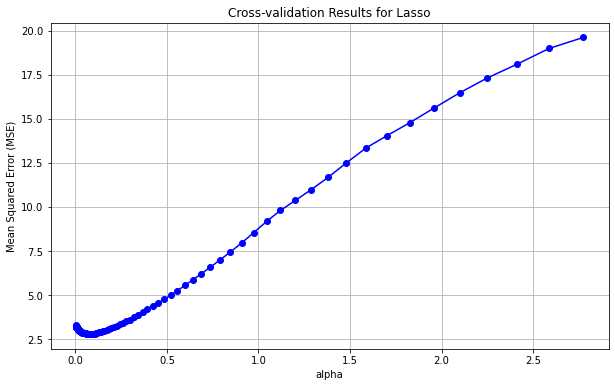

Intercept (beta0): 1.2762324862184158
Lasso coefficients: [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -2.71982685  0.         -0.05745334 -0.
 -0.         -0.         -0.39585533 -0.23276644  0.          0.
 -0.          0.          0.         -0.22180365 -1.15847952  0.77569425
 -0.         -1.27950133  0.          0.          0.06530332  0.
 -0.          0.         -0.10847216  0.25740072  0.01277731  0.
  0.          0.         -0.18839793  0.         -0.          0.
  0.          0.0186891   1.63196351 -0.01838965  0.69384574 -0.08473514
  0.          0.        ]


AttributeError: 'LassoCV' object has no attribute 'coef_path'

In [59]:
import pandas as pd
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training data
X_scaled = scaler.fit_transform(X.values)

# Start the timer
start_time = datetime.now()

# Perform 10-fold cross-validation to find the best value of alpha (lambda)
lasso_cv = LassoCV(cv=10, random_state=15)  # Set a random state for reproducibility
lasso_cv.fit(X_scaled, y.values)

# The best model's alpha value (lambda) found during cross-validation
best_alpha = lasso_cv.alpha_
print(f"The best value of alpha (lambda) found via 10-fold cross-validation is: {best_alpha}")

# Retrieve the alphas and corresponding MSE values
alphas = lasso_cv.alphas_
mse_values = lasso_cv.mse_path_.mean(axis=1)

# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Cross-validation Results for Lasso')
plt.grid(True)
plt.show()

# End the timer
end_time = datetime.now()

print(f"Intercept (beta0): {lasso_cv.intercept_}")
print(f"Lasso coefficients: {lasso_cv.coef_}")

cvfit$gamlr$beta[,100]

# Predict function using the fitted Lasso model
def lasso_predict(X, lasso, scaler):
    # Scale the features before prediction
    X_scaled = scaler.transform(X)
    return lasso.predict(X_scaled)

# Load the test data
test_data = pd.read_csv('test_data.csv')

# Prepare the test data features and target
# Assuming the variable `target_column` is defined as the name of the target column
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column].values

# Make predictions on the test set
y_test_pred = lasso_predict(X_test.values, lasso_cv, scaler)

# Calculate the MSE for the test set
mse_test_lasso = mean_squared_error(y_test, y_test_pred)

print(f"MSE for the test set is: {mse_test_lasso}")


<div class="alert alert-block" style="background-color: green; color: white; text-align: center;"><span style="font-size: 14px;"> 
<strong>Results</strong>

In [17]:
# Group the results by 'K' and calculate the mean of the MSE for each 'K'
mean_mses = results_df.groupby('K')['Mean_Squared_Error'].mean()
mean_mse_train = results_df.groupby('K')['Mean_Squared_Error_train'].mean()

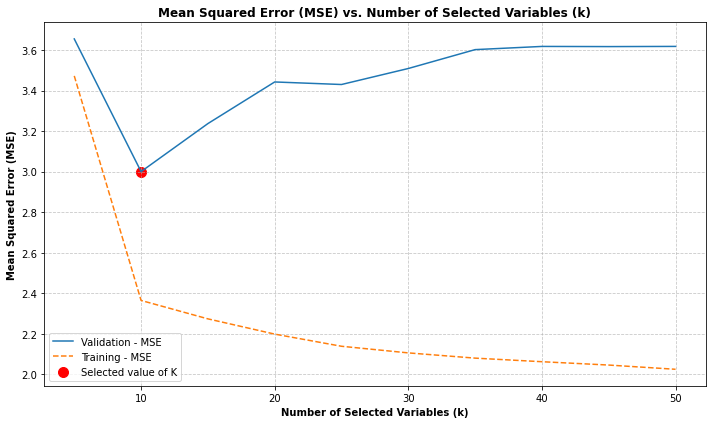

In [49]:
# Create the main figure with one subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 60-day moving averages for NASDAQ Index, MSFT, and MXIM
ax.plot(mean_mses, label='Validation - MSE', linestyle='-')
ax.plot(mean_mse_train, label='Training - MSE', linestyle='--')

# Add a grid
ax.grid(False)
plt.xlabel('Number of Selected Variables (k)', weight='bold')
plt.ylabel('Mean Squared Error (MSE)', weight='bold')
plt.title('Mean Squared Error (MSE) vs. Number of Selected Variables (k)', weight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add a circle to highlight the point (10, 3)
highlight_x = 10
highlight_y = 3
ax.scatter([highlight_x], [highlight_y], color='red', marker='o', s=100, label='Selected value of K')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


,Fold,K,Betas,Intercept,Squared_Error,Mean_Squared_Error,Fold_Size,Mean_Squared_Error_train,NonZeroCount
0,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, -2.4770180947332374, ...",1.048318,130.882726,5.235309,25,3.294818,5
1,2,5,"[0, 0, 0, 0, 0, 0, 0, 0, -2.4336028823407556, ...",1.005064,54.125122,2.165005,25,3.637798,5
2,3,5,"[0, 0, 0, 0, 0, 0, 0, 0, -2.4005720263491717, ...",1.111027,98.443774,3.937751,25,3.437075,5
3,4,5,"[0, 0, 0, 0, 0, 0, 0, 0, -2.4387128010410692, ...",1.064673,134.926885,5.397075,25,3.283148,5
4,5,5,"[0, 0, 0, 0, 0, 0, 0, 0, -2.3952840761589385, ...",1.055358,98.889777,3.955591,25,3.438853,5
...,...,...,...,...,...,...,...,...,...
95,6,50,"[-0.09730319482878258, 0.0989966098768491, 0.1...",0.961317,110.982374,4.439295,25,1.985918,50
96,7,50,"[-0.30810613545509113, 0.0455809806844627, 0.1...",0.981846,64.054721,2.562189,25,2.105047,50
97,8,50,"[0.12394178814793122, 0.21579900523829565, 0.3...",0.938291,77.819541,3.112782,25,2.069291,50
98,9,50,"[-0.2406860020946624, 0.12090279579024354, 0.3...",0.961056,58.948740,2.357950,25,2.115085,50
